In [23]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import pymongo
from collections import Counter
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community.centrality import girvan_newman

### Dataframe functions

In [2]:
def create_dataframe(recipes, cutoff=None):
    if cutoff == None:
        cutoff = int(len(recipes)**(1/3))
    print('Ingredient cutoff : {} occurrences'.format(cutoff))
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names, limit=None):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    label_nums = [ordered_names.index(label) for label in label_names]
    if not limit:
        return ordered_names, label_nums
    else:
        abbr_names = ordered_names[:limit-1] + ['Other']
        abbr_nums = [num if num < limit-1 else limit-1 for num in label_nums]
        return abbr_names, abbr_nums

### Recipe search functions

In [3]:
def find_recipes_matching_search(collection, search_term):
    matching_recipes = []
    for recipe in collection.find():
        flag = False
        if len(recipe['name'].lower().split(search_term.lower())) > 1:
            flag = True
        if recipe['category']['lvl_2']:
            if len(recipe['category']['lvl_2'].lower().split(search_term.lower())) > 1:
                flag = True
        if recipe['category']['lvl_3']:
            if len(recipe['category']['lvl_3'].lower().split(search_term.lower())) > 1:
                flag = True
        if flag:
            matching_recipes.append(recipe)
    return matching_recipes

### Find matching recipes

In [4]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [5]:
recipes = find_recipes_matching_search(recipes_coll, 'chili')
len(recipes)

297

### Graph results

In [6]:
df = create_dataframe(recipes)
df.shape

Ingredient cutoff : 6 occurrences


(297, 79)

In [7]:
X = df.values
label_names = get_label_names(recipes, cat_lvl=3)
ordered_names, label_nums = get_label_numbers(label_names, limit=4)
cosine_sims = cosine_similarity(X)

Threshold cosine similarity : 0.74


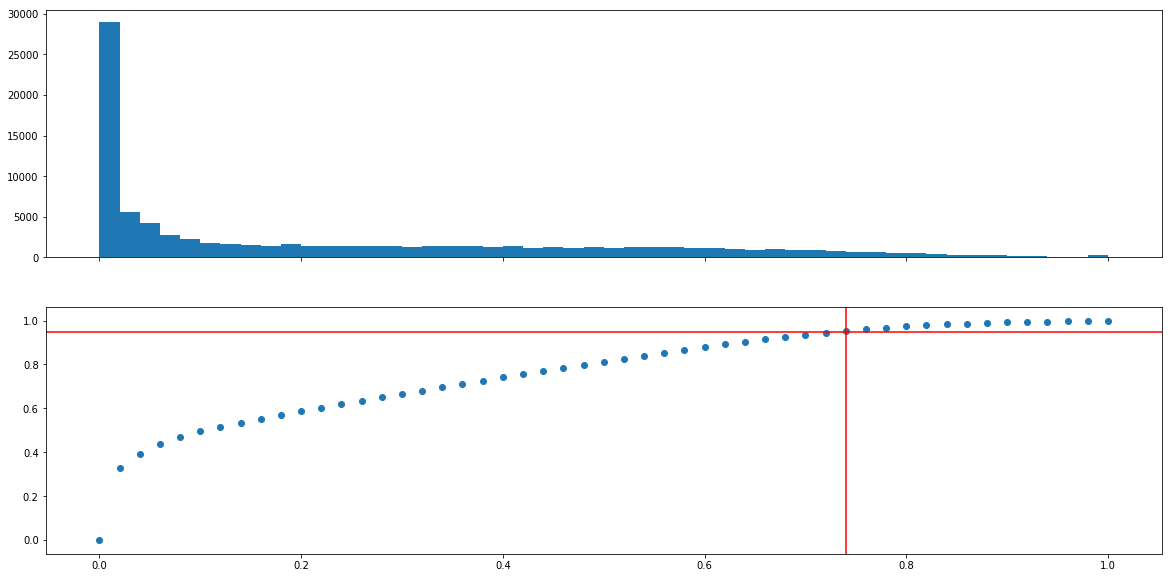

In [8]:
threshold = 0.95
fig, axs = plt.subplots(2,1, figsize=(20,10), sharex=True)
bins = axs[0].hist(cosine_sims.flatten(), bins=50)
cumulative = [np.sum(bins[0][:i])/np.sum(bins[0]) for i in range(len(bins[0])+1)]
axs[1].scatter(bins[1], cumulative)
axs[1].axhline(threshold, c='r')
for i, total in enumerate(cumulative):
    if total > threshold:
        axs[1].axvline(bins[1][i], c='r')
        print('Threshold cosine similarity : {0:0.2f}'.format(bins[1][i]))
        break

In [132]:
def remove_isolates(G, min_size=3):
    for comm in nx.components.connected_components(G.copy()):
        if len(comm) < min_size:
            for node in comm:
                G.remove_node(node)

In [107]:
G = nx.Graph()
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > 0.7:
            G.add_edge(i, j, weight=100*cosine_sims[i,j])

remove_isolates(G, 3)

In [88]:
def plot_weighted_graph(G, ax, k=0.5):
    eigen_centralities = nx.eigenvector_centrality(G)
    eigen_array = np.array([val for key, val in eigen_centralities.items()])
    node_colors = [cm.jet(eig/np.max(eigen_array)) for eig in eigen_array]

    betweenness = nx.edge_betweenness_centrality(G)
    between_array = np.array([val for key, val in betweenness.items()])
    edge_colors = [cm.jet(bet/np.max(between_array)) for bet in between_array]

    spring = nx.spring_layout(G, k=k, weight='weight', seed=427)
    nx.draw_networkx_nodes(G,
                           pos=spring,
                           node_size=150 * eigen_array/np.max(eigen_array) + 10,
                           node_color=node_colors,
                           ax=ax,
                           alpha=0.5,
                           with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color=edge_colors,
                           width=8 * between_array/np.max(between_array) + 0.1,
                           alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([]);
    #ax.set_xlim(left=-.5, right=.5)
    #ax.set_ylim(bottom=-.5, top=.5);

/Users/heilman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


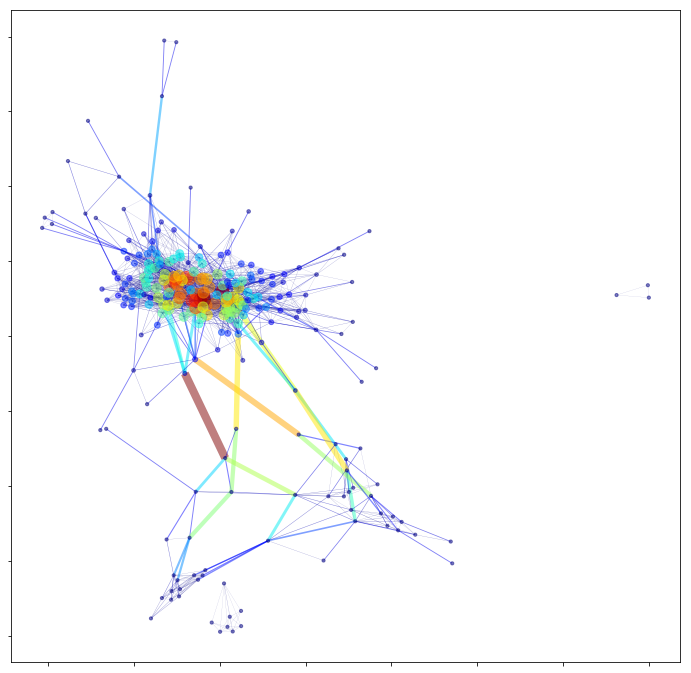

In [108]:
fig, ax = plt.subplots(figsize=(12,12))
plot_weighted_graph(G, ax, .5)

### Cluster into communities and generate names

In [ ]:
def split_graph(G):
    initial_communities = nx.components.number_connected_components(G)
    while initial_communities == nx.components.number_connected_components(G):
        betweenness = nx.edge_betweenness_centrality(G)
        edge_array = np.array([key for key, val in betweenness.items()])
        between_array = np.array([val for key, val in betweenness.items()])
        most_important_edge = edge_array[np.argmax(between_array)]
        G.remove_edge(most_important_edge[0], most_important_edge[1])

In [ ]:
nx.components.number_connected_components(G)

In [109]:
split_graph(G)
nx.components.number_connected_components(G)

4

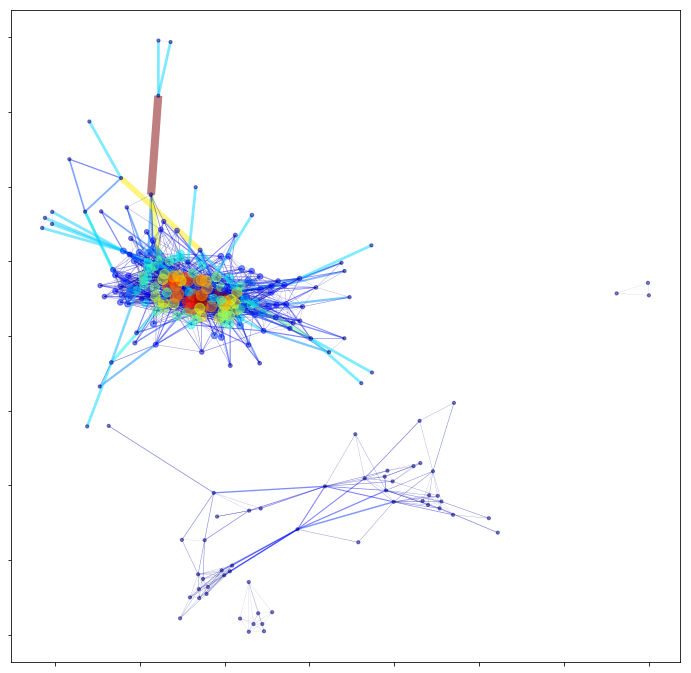

In [135]:
fig, ax = plt.subplots(figsize=(12,12))
plot_weighted_graph(G, ax, .5)

In [97]:
def get_recipe_names(node_set, recipe_ids, recipe_list):
    recipe_names = []
    for node in node_set:
        r_id = recipe_ids[node]
        for recipe in recipe_list:
            if recipe['id'] == r_id:
                recipe_names.append(recipe['name'])
                break
    return recipe_names

In [111]:
clustered_recipe_names = []
for component in nx.components.connected_components(G):
    clustered_recipe_names.append(get_recipe_names(component, df.index, recipes))

In [118]:
clustered_recipe_names[1]

['Chili Chicken Stew',
 'Chili Verde',
 'Award-Winning White Chicken Chili',
 'White Bean Chicken Breast Chili',
 "Michelle's Blonde Chicken Chili",
 'Easy White Chicken Chili',
 'Easy White Chili',
 'Venison Chili',
 'Spicy White Chili with Chicken',
 'White Chili',
 'Slow Cooker Chicken Chili',
 'Red Curry Chicken Chili',
 'Smoked Sausage White Bean Chili',
 "Cha Cha's White Chicken Chili",
 'White Bean, Turkey, and Sausage Chili',
 'Chicken and Corn Chili',
 'White Chili I',
 'Chilly Day Chili',
 'White Chili II',
 'Slow Cooker White Chili',
 'Crock-Pot® Chicken Chili',
 'White Chili I',
 'Southwest White Chicken Chili',
 "Chef John's Green Chicken Chili",
 'Hearty Chili Chicken & Rice',
 'Colorado Green Chili (Chile Verde)',
 'Sweet Chili Lime Chicken with Cilantro Couscous',
 'White Chili IV',
 'Venison-Bacon White Chili',
 'Chili-Lime Chicken Kabobs',
 'Chicken and White Bean Chili',
 "Carol's Chicken Chili",
 'Easy White Chili II',
 'White Chili VI',
 'Super Easy Chicken Chili',

In [124]:
subgraphs = nx.components.connected_component_subgraphs(G)
subG1 = next(subgraphs)

/Users/heilman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


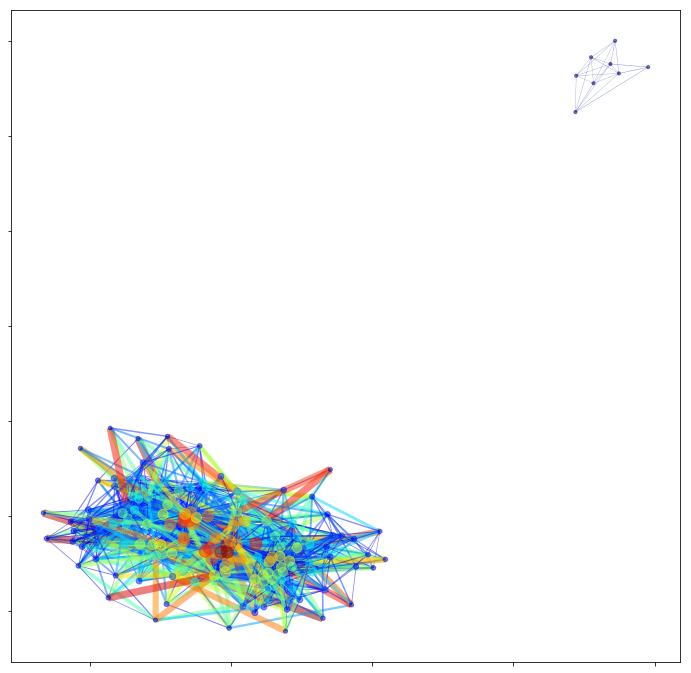

In [139]:
fig, ax = plt.subplots(figsize=(12,12))
plot_weighted_graph(subG1, ax, .5)

In [138]:
n_communities = nx.components.number_connected_components(subG1)
while n_communities < 2:
    print('Splitting...')
    split_graph(subG1)
    remove_isolates(subG1, 5)
    n_communities = nx.components.number_connected_components(subG1)

Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...
Splitting...


In [140]:
clustered_recipe_names = []
for component in nx.components.connected_components(subG1):
    clustered_recipe_names.append(get_recipe_names(component, df.index, recipes))

In [142]:
clustered_recipe_names[1]

['The Best Turkey Chili',
 'Waistline-Friendly Turkey Chili',
 "Smokin' Scovilles Turkey Chili",
 'Firehouse Station 2 Healthy Chili',
 'Quinoa and Black Bean Chili',
 'Black Bean and Chickpea Chili',
 'Rhubarb Chili',
 'Pumpkin Turkey Chili']

In [144]:
subG2 = next(nx.components.connected_component_subgraphs(subG1))

In [145]:
n_communities = nx.components.number_connected_components(subG2)
while n_communities < 2:
    #print('Splitting...')
    split_graph(subG2)
    remove_isolates(subG2, 5)
    n_communities = nx.components.number_connected_components(subG2)

/Users/heilman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


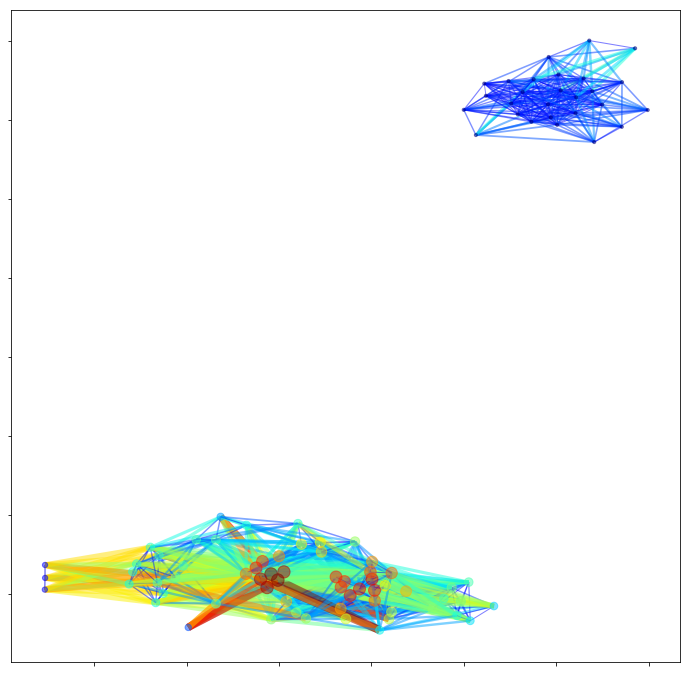

In [146]:
fig, ax = plt.subplots(figsize=(12,12))
plot_weighted_graph(subG2, ax, .5)

In [147]:
clustered_recipe_names = []
for component in nx.components.connected_components(subG2):
    clustered_recipe_names.append(get_recipe_names(component, df.index, recipes))

In [152]:
clustered_recipe_names[0]

["Dad's Chili",
 'Russian Chili',
 'Chili-ghetti',
 'Touchdown Chili',
 'Fusion Chili',
 'Camp Chili',
 "JRay's Chili",
 "Chili Rick's",
 "Miner's Chili",
 'Pumpkin Chili',
 'Pressure Cooker Chili',
 'Chili IV',
 'Tequila Chili',
 'Simple Chili',
 "Mom's Chili",
 "Bob's Little Known, Less Cared About Chili",
 "Kas' Chili",
 'Easy Texas Chili',
 'Three Bean Slow Burn Chili',
 'Homemade Chili',
 'Award Winning Chili Con Carne',
 'Hearty Chili',
 "Fairuzah's Chili",
 'Killer Chili',
 'Sweet Potato Chili',
 'Award Winning Chili',
 'Quick and Spicy Chili',
 'Minnesota Golf Course Chili',
 'Spicy Slow-Cooked Chili',
 'Five Meat Habanero Chili',
 'Spicy Slow-Cooked Beanless Chili',
 'Chicken Chili Soup',
 'Wicked Good Veggie Chili',
 'Slow Cooker Chipotle Chili',
 'Taco Chili from Publix®',
 "Jammin' Tarheel Chili",
 'Easy Slow Cooker Chili',
 'Chili con Carne I',
 'Chili II',
 'Chili con Carne II',
 "Emily's Chipotle Chili",
 'Darn Good Chili',
 'Wicked Easy Chili',
 'Italian Style Chili',
 

### Find weighted centers of largest/most relevant communities

### Convert cluster centers into recipes

### Approximate confidence in recipes and present to user